# Depth Reconstruction with Deep Neural Networks - Exercise

In this exercise we will learn how to implement a network to perform depth reconstruction from a single image, following the seminal work of Eigen et al \[2014, 2015\].
* https://openaccess.thecvf.com/content_iccv_2015/papers/Eigen_Predicting_Depth_Surface_ICCV_2015_paper.pdf
* https://arxiv.org/pdf/1406.2283.pdf

We will work with the [KITTI](http://www.cvlibs.net/datasets/kitti/eval_scene_flow.php?benchmark=stereo) dataset for training data. We will see how to load the data, augment it and wrap it for usage in Tensorflow.

Load and import some required packages:

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
import skimage.measure
import albumentations as A
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Conv2DTranspose, UpSampling2D

## Data

Obtain the depth reconstruction dataset from KITTI:

Very quick verification that the data is valid:

In [2]:
kittiL = cv2.imread('data_scene_flow/training/image_2/000001_10.png')[:,:,::-1]
kittiDL = skimage.measure.block_reduce(cv2.imread('data_scene_flow/training/image_2/000001_10.png', 0), (8, 8), np.max)

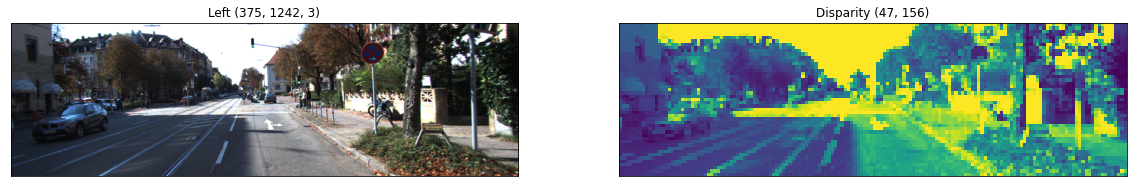

In [3]:
fig = plt.figure(figsize=(20,5))
plt.subplot(121),plt.imshow(kittiL),plt.title(f'Left {kittiL.shape}');
plt.subplot(122),plt.imshow(kittiDL),plt.title(f'Disparity {kittiDL.shape}');
plt.setp(fig.get_axes(), xticks=[], yticks=[]);

#### Input Size 
Since we use factor-2 convolutions, we will adjust the resultions of the images to multiples of 2: (192, 640) and (48, 160). These are very close approximations of the real uniform aspect-preserving scale of the data at (192, 636) and (48, 159).

This will allow us to chain many convolutions without risk of fractional pixels.

## Building a data loading & augmentation pipeline

To train the model efficiently, e.g. on a GPU, it's recommended to build a data loading pipeline, so that different parts (like resizing, augmenting) can be accelerated on the GPU.

We provided the dataset creation and augmentation code. Review the code to understand what it does.

Tensorflow provide a very good article on data augmentation: https://www.tensorflow.org/tutorials/images/data_augmentation#apply_augmentation_to_a_dataset

In [4]:
list_ds = tf.data.Dataset.list_files('data_scene_flow/training/image_2/*_10.png')

def process_path(file_path, seed):
    parts = tf.strings.split(file_path, os.sep)
    label_file = tf.strings.join([parts[0],parts[1], 'disp_noc_0', parts[3]], os.sep)

    # Make a new seed so that random transformation is consistent between image
    # and label depth map
    new_seed = tf.random.experimental.stateless_split(seed, num=1)[0, :]
  
    image = tf.io.read_file(file_path)
    image = tf.image.decode_png(image)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [192, 640])
    image = tf.image.stateless_random_brightness(image, max_delta=0.3, seed=new_seed)
    image = tf.clip_by_value(image, 0, 1)
    image = tf.image.stateless_random_flip_left_right(image, seed=seed)
    image.set_shape((192, 640, 3))

    disp = tf.io.read_file(label_file)
    disp = tf.image.decode_png(disp)
    disp = tf.image.convert_image_dtype(disp, tf.float32)
    disp = tf.nn.max_pool2d(tf.expand_dims(disp, 0), (8, 8), 8, 'VALID')
    disp = tf.image.stateless_random_flip_left_right(disp, seed=seed)
    disp = tf.image.flip_left_right(disp)
    disp = tf.image.resize(disp, size=(48, 160))
    disp = tf.squeeze(disp)
    disp = disp * 255.0
    disp.set_shape((48, 160))

    rot_factor = tf.random.uniform(shape=[], minval=-7.0, maxval=7.0, dtype=tf.float32)
    angle = np.pi/180*rot_factor
    image = tfa.image.rotate(image, angle, fill_mode='nearest')
    disp = tfa.image.rotate(disp, angle, fill_mode='nearest')

    return image, disp


counter = tf.data.experimental.Counter()
train_ds = tf.data.Dataset.zip((list_ds, (counter, counter)))
validation_files = train_ds.take(10)
train_ds = train_ds.skip(10)

labeled_ds = train_ds.map(process_path, num_parallel_calls=4)
labeled_ds = labeled_ds.batch(32, drop_remainder=True).prefetch(buffer_size=32).repeat()

val_ds = validation_files.map(process_path).batch(5)

NotImplementedError: in user code:

    <ipython-input-4-985a867b3aae>:33 process_path  *
        image = tfa.image.rotate(image, angle, fill_mode='nearest')
    D:\Anaconda3\envs\pytorch\lib\site-packages\tensorflow_addons\image\transform_ops.py:360 rotate  *
        output = transform(
    D:\Anaconda3\envs\pytorch\lib\site-packages\tensorflow_addons\image\transform_ops.py:295 angles_to_projective_transforms  *
        return tf.concat(
    D:\Anaconda3\envs\pytorch\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper  **
        return target(*args, **kwargs)
    D:\Anaconda3\envs\pytorch\lib\site-packages\tensorflow\python\ops\array_ops.py:2911 wrapped
        tensor = fun(*args, **kwargs)
    D:\Anaconda3\envs\pytorch\lib\site-packages\tensorflow\python\ops\array_ops.py:2960 zeros
        output = _constant_if_small(zero, shape, dtype, name)
    D:\Anaconda3\envs\pytorch\lib\site-packages\tensorflow\python\ops\array_ops.py:2896 _constant_if_small
        if np.prod(shape) < 1000:
    <__array_function__ internals>:5 prod
        
    D:\Anaconda3\envs\pytorch\lib\site-packages\numpy\core\fromnumeric.py:3030 prod
        return _wrapreduction(a, np.multiply, 'prod', axis, dtype, out,
    D:\Anaconda3\envs\pytorch\lib\site-packages\numpy\core\fromnumeric.py:87 _wrapreduction
        return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
    D:\Anaconda3\envs\pytorch\lib\site-packages\tensorflow\python\framework\ops.py:867 __array__
        raise NotImplementedError(

    NotImplementedError: Cannot convert a symbolic Tensor (rotate/angles_to_projective_transforms/strided_slice_1:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported


Let's test the `tf.Dataset` pipeline:

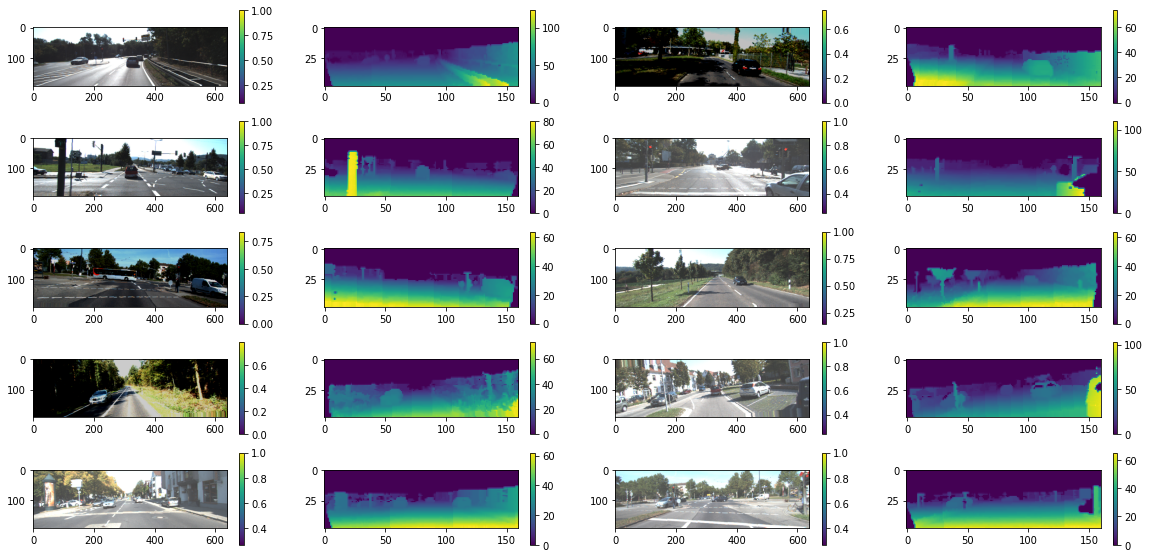

In [13]:
fig= plt.figure(figsize=(20, 20))
for i_f, f in enumerate(labeled_ds.take(1)):
    for i in range(10):
        plt.subplot(10,4,i_f*10 + 2*i + 1),plt.imshow(f[0][i].numpy()),plt.colorbar();
        plt.subplot(10,4,i_f*10 + 2*i + 2),plt.imshow(f[1][i].numpy()),plt.colorbar();

Test the validation dataset:

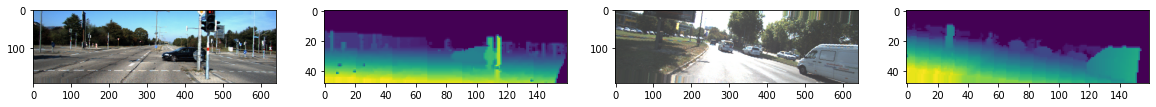

In [14]:
fig= plt.figure(figsize=(20, 20))
for i_f, f in enumerate(val_ds.take(1)):
    for i in range(2):
        plt.subplot(10,4,i_f*2 + 2*i + 1),plt.imshow(f[0][i].numpy());
        plt.subplot(10,4,i_f*2 + 2*i + 2),plt.imshow(f[1][i].numpy());

## The Model Architecture

Eigen et al build a two-stream network for coarse and fine reconstruction.

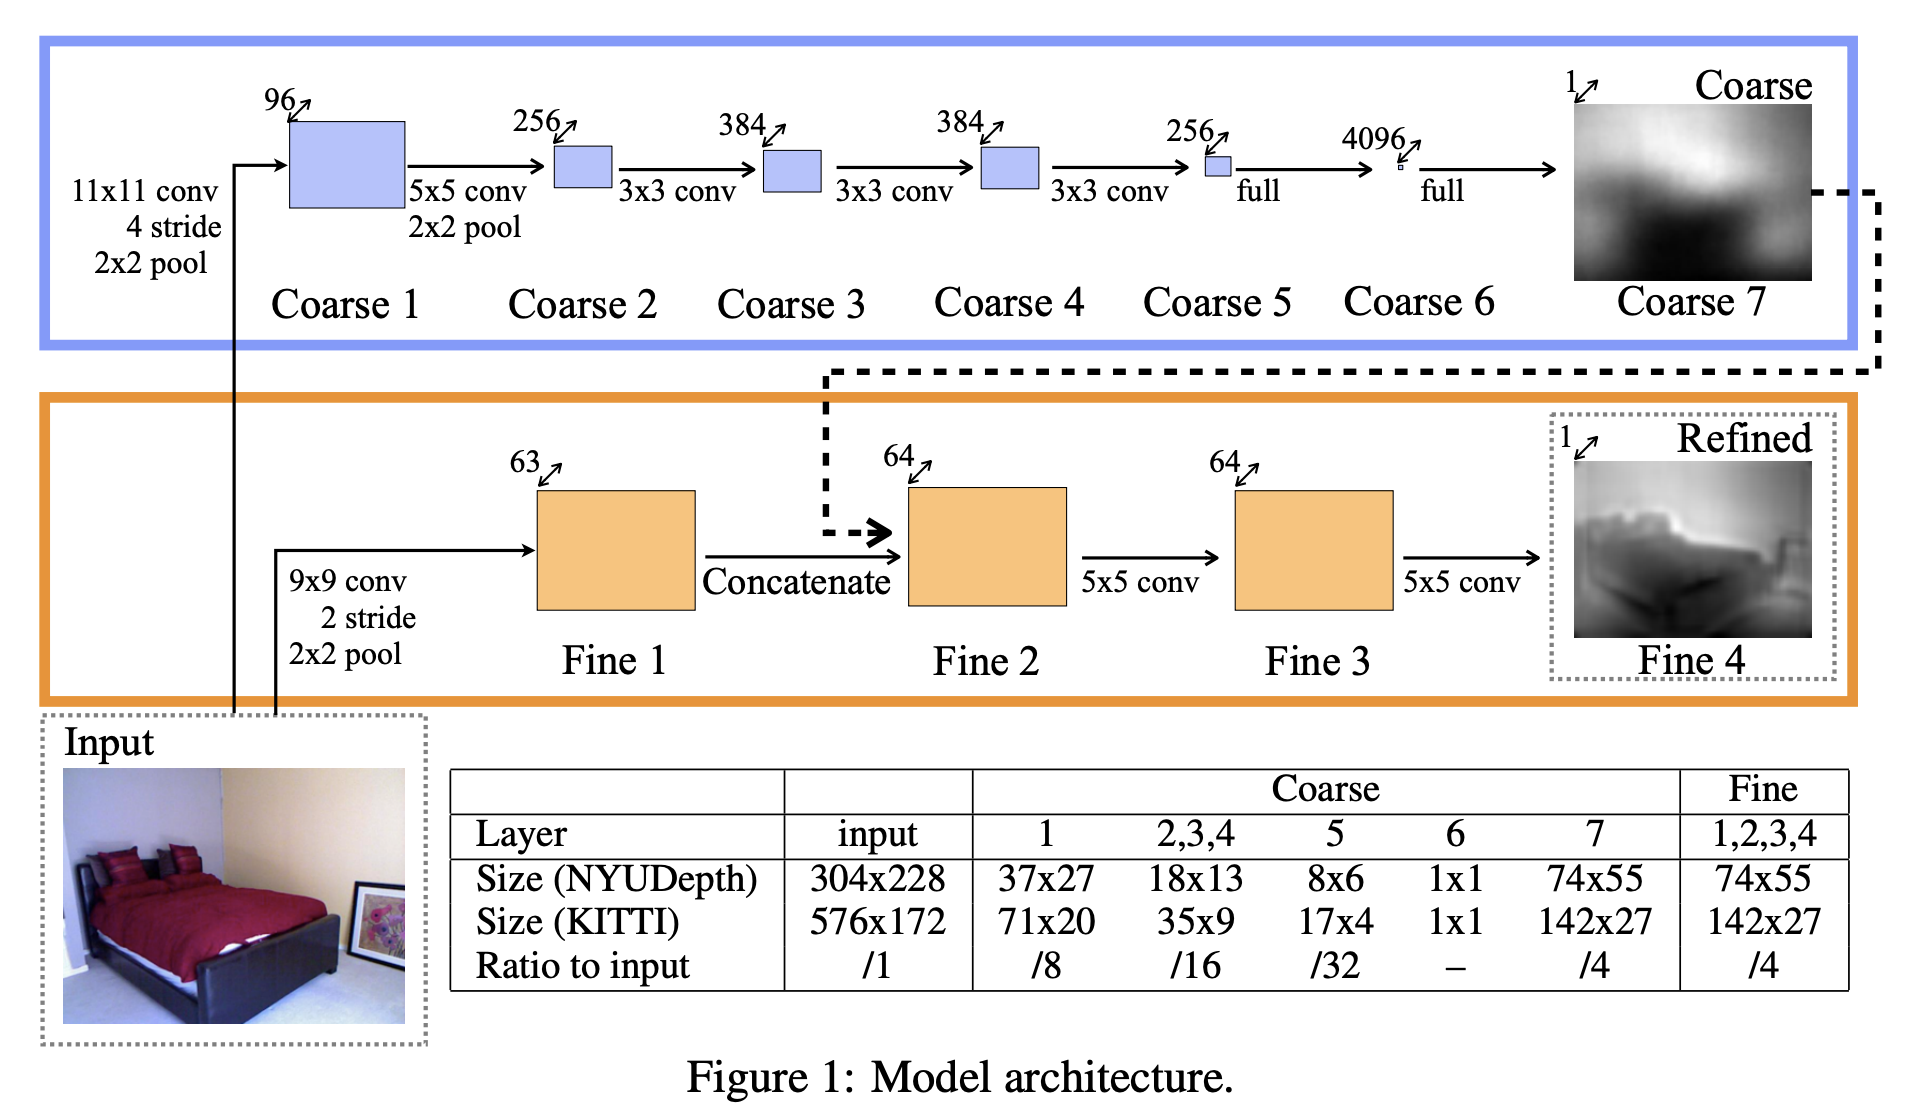

However, the final two fully connected layers introduce an ***enormous*** amount of parameters to optimize. On the order of 100,000,000. 
This is not tractable for training using the time or data we have at hand.

We will therefore replace that part of the network with a convolutional decoder. Using convolutions instead of a fully connected layers reduced the entire model to 3,000,000 parameters, which is well within the realm of tractability.

The architecture is as follows:

**Coarse Stream**
1. Conv 2D, 96 filters, 11x11, stride 4x4 + BatchNorm + ReLU + MaxPool2D (2x2)
2. Conv 2D, 256 filters, 5x5, stride 2x2 + BN + ReLU
3. Conv 2D, 384 filters, 3x3 + BN + ReLu + MaxPool2D (2x2)
4. Conv 2D Transpose, 256 filters, 3x3 + BN + UpSampling2D (2x2) + ReLU
5. Conv 2D Transpose, 96 filters, 3x3 + BN + UpSampling2D (2x2) + ReLU
6. Conv 2D Transpose, 64 filters, 3x3 + BN + UpSampling2D (2x2) + ReLU

**Fine Stream**
1. Conv 2D, 64 filters, 9x9, stride 2x2 + BN + ReLU + MaxPool2D (2x2)
2. Concatenate output from Coarse Stream, e.g number 6 from above (the output of this operation will be \[?, 48, 160, 128\])
3. Conv 2D, 64 filters, 5x5 + BN + ReLU
4. Conv 2D, 64 filters, 5x5 + BN + ReLU
5. Conv 2D, 1 filter, 3x3, **Linear activation** - this is the output predicted depth map at \[?, 48, 160, 1\]
In the next block, implement the convolutional model.

The input and output shapes ([192, 640, 3] and [48, 160] respectively) are fixed for you since they match the input data.

Use `layers.Conv2D`, `layers.MaxPool2D`, `layers.Activation`, `layers.BatchNormalization`, `layers.Conv2DTranspose`, `layers.UpSampling2D`

In [7]:
def make_model():
    inputs = keras.Input(shape=(192, 640, 3))

    # "Coarse" stream

    # encoder
    Coarse1_conv = keras.layers.Conv2D(96, (11, 11), (4, 4))(inputs)
    Coarse1_bn   = keras.layers.BatchNormalization()(Coarse1_conv)
    Coarse1_act  = keras.layers.ReLU()(Coarse1_bn)
    Coarse1      = keras.layers.MaxPool2D((2, 2))(Coarse1_act)

    Coarse2_conv = keras.layers.Conv2D(256, (5, 5), (2, 2))(Coarse1)
    Coarse2_bn   = keras.layers.BatchNormalization()(Coarse2_conv)
    Coarse2      = keras.layers.ReLU()(Coarse2_bn)

    Coarse3_conv = keras.layers.Conv2D(384, (3, 3))(Coarse2)
    Coarse3_bn   = keras.layers.BatchNormalization()(Coarse3_conv)
    Coarse3_act  = keras.layers.ReLU()(Coarse3_bn)
    Coarse3      = keras.layers.MaxPool2D((2, 2))(Coarse3_act)

    # decoder

    Coarse4_conv = keras.layers.Conv2DTranspose(256, (3, 3))(Coarse3)
    Coarse4_bn   = keras.layers.BatchNormalization()(Coarse4_conv)
    Coarse4_us   = keras.layers.UpSampling2D((2, 2))(Coarse4_bn)
    Coarse4      = keras.layers.ReLU()(Coarse4_us)

    Coarse5_conv = keras.layers.Conv2DTranspose(96, (3, 3), padding='same')(Coarse4)
    Coarse5_bn   = keras.layers.BatchNormalization()(Coarse5_conv)
    Coarse5_us   = keras.layers.UpSampling2D((2, 2))(Coarse5_bn)
    Coarse5      = keras.layers.ReLU()(Coarse5_us)

    Coarse6_conv = keras.layers.Conv2DTranspose(64, (3, 3), padding='same')(Coarse5)
    Coarse6_bn   = keras.layers.BatchNormalization()(Coarse6_conv)
    Coarse6_us   = keras.layers.UpSampling2D((2, 2))(Coarse6_bn)
    Coarse6      = keras.layers.ReLU()(Coarse6_us)

    # "Fine" stream
    Fine1_conv = keras.layers.Conv2D(64, (9, 9), (2, 2), padding='same')(inputs)
    Fine1_bn   = keras.layers.BatchNormalization()(Fine1_conv)
    Fine1_act  = keras.layers.ReLU()(Fine1_bn)
    Fine1      = keras.layers.MaxPool2D((2, 2))(Fine1_act)

    # add coarse output in ...
    Fine2_in   = tf.concat([Fine1, Coarse6], 3)
    Fine2_conv = keras.layers.Conv2D(64, (5, 5), padding='same')(Fine2_in)
    Fine2_bn   = keras.layers.BatchNormalization()(Fine2_conv)
    Fine2      = keras.layers.ReLU()(Fine2_bn)

    Fine3_conv = keras.layers.Conv2D(64, (5, 5), padding='same')(Fine2)
    Fine3_bn   = keras.layers.BatchNormalization()(Fine3_conv)
    Fine3      = keras.layers.ReLU()(Fine3_bn)

    Fine4      = keras.layers.Conv2D(1, (3, 3), activation='linear', padding='same')(Fine3)

    # padding to keep shape (48, 160)

    outputs = Fine4

    return keras.Model(inputs, outputs)



Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 640, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 46, 158, 96)  34944       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 46, 158, 96)  384         conv2d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 46, 158, 96)  0           batch_normalization[0][0]        
______________________________________________________________________________________________

Verify that your model is the way you expect it, and that there are no errors with tensor shapes:

In [ ]:
model = make_model()
model.summary()

## Loss function

Loss function from the Eigen et al. 2015 paper:

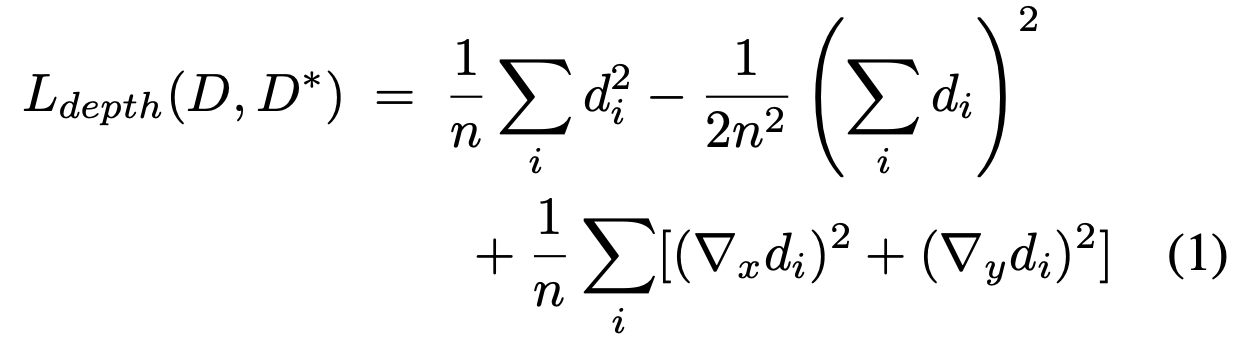

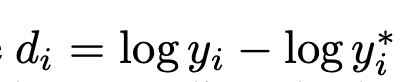

Note that we only need to "actively" take the log of the **ground truth** depth map, since the network will already try to predict the log-depth, so we can compare **directly** the `tf.math.log(y_true)` vs `y_pred` (no need to take the log of `y_pred`).

Also note that Eigen et al say "the sums are over valid pixels `i`, and `n` is the number of valid pixels (we mask out pixels where the ground truth is missing).

To that end use the `tf.where()` and `tf.greater()` functions to only calculate the logarithm in pixels with valid values (e.g. > 0). Logarithm is `-inf` on 0 values, which will derail our calculations.

You can use the `tf.math.count_nonzero` function to calculate `n` directly.

Start by calculating `d` in terms of `y_pred, y_true`, and use it with `tf.reduce_sum` and `tf.square` to get the calculations you require.

In [ ]:
def eigen_2015_loss(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=float)
    y_pred = tf.cast(y_pred, dtype=float)
    
    # Calculate d from y_true and y_pred
    # d = ...
    d = tf.where(tf.greater(y_true, 0), tf.math.log(y_true) - y_pred, tf.zeros_like(y_true))
    
    # Get `n` from `y_true`. Don't forget to tf.cast to tf.float32
    # n = ...
    n = tf.math.count_nonzero(y_true, axis=[1, 2, 3])
    n = tf.cast(n, float)
    
    # Calculate data term
    # data_term = ...
    data_term = tf.reduce_sum(tf.square(d), axis=[1, 2, 3])
    data_term = tf.divide(data_term, n)
    
    # Calculate direction term
    # direction_term = ...
    direction_term = tf.reduce_sum(d, axis=[1, 2, 3])
    direction_term = tf.square(direction_term)
    direction_term = -tf.divide(direction_term, 2 * tf.square(n))
    
    # Calculate gradient matching term
    # matching_term = ...
    grad_x_kernel = tf.constant(
        [[[[0.0]], [[-1.0]], [[0.0]]], [[[0.0]], [[0.0]], [[0.0]]], [[[0.0]], [[1.0]], [[0.0]]]])
    grad_y_kernel = tf.constant(
        [[[[0.0]], [[0.0]], [[0.0]]], [[[-1.0]], [[0.0]], [[1.0]]], [[[0.0]], [[0.0]], [[0.0]]]])
    di_grad_x = tf.nn.conv2d(d, grad_x_kernel, strides=[1, 1, 1, 1], padding='SAME')
    di_grad_y = tf.nn.conv2d(d, grad_y_kernel, strides=[1, 1, 1, 1], padding='SAME')
    di_grad_x = tf.reduce_sum(tf.square(di_grad_x), axis=[1, 2, 3])
    di_grad_y = tf.reduce_sum(tf.square(di_grad_y), axis=[1, 2, 3])
    matching_term = tf.divide(di_grad_x + di_grad_y, n)
    
    return data_term + direction_term + matching_term

## Training the model

We will train the model with the `keras.optimizers.Adam` optimizer. 
* Learning rate = `1e-3`
* Number of Epochs = 150
* Steps per epoch = 20
Compile your model with `model.compile(...)`, and add the custom loss function you've created `eigen_2015_loss`.

Write a callback using `keras.callbacks.ModelCheckpoint` to monitor the `val_loss` metric, and `save_best_only=True`. This will create a saved point for us later to load and test on our data.

Don't forget to supply the validation data `val_ds` in `validation_data` in the `model.fit()` function.

In [ ]:
epochs = 150
learning_rate = 1e-3

# make model ...
model = make_model()

# compile with keras.optimizers.Adam and eigen_2015_loss
# ...
model.compile(loss=None, optimizer=keras.optimizers.Adam(lr=learning_rate), metrics=['accuracy'])

callbacks = [
    # ...
]

Call the `.fit()` function of the model with the `labeled_ds` and `val_ds` datasets.
This may take ~20-30 minutes to complete. Select a GPU runtime. Training on CPU will be too slow, and may take hours to finish.

In [ ]:
history = model.fit(labeled_ds, y_train,
          batch_size=BATCH_SIZE,
          epochs=epochs,
          verbose=1,
          validation_data=(val_ds, y_test),
          callbacks=[history])

Visualize the learning curves

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5), logy=True)
plt.show()

### Model Training Matters

You should see a consistent decrease in the loss, up to a point. The validation loss should follow the training loss. If they diverge - it's most likely a sign of overfitting and training should be stopped.

If your model is making no progress in learning and is stuck in a plateau at a high loss value (e.g. > 1.0), examine your loss function carefully and disable all but the "data term". Return to your model architecture and make sure the activations are correct (e.g. a "linear" activation for the final prediction layer). You may try also to disable the "Fine" stream and only keep the "Coarse" stream, and see if that allows the network to converge.

### Visualize prediction results

In [ ]:
# restore the best model
model.load_weights('save_best.h5')

In [ ]:
plt.figure(figsize=(20,10))
for_test = next(iter(val_ds.take(1)))
for i in range(5):
    plt.subplot(5,3,3*i + 1),plt.imshow(np.exp(model.predict(for_test[0])[i,:,:,0])),plt.colorbar();
    plt.subplot(5,3,3*i + 2),plt.imshow(for_test[1][i].numpy()), plt.colorbar();
    plt.subplot(5,3,3*i + 3),plt.imshow(for_test[0][i].numpy());

## Evaluation metrics

Since KITTI do not provide ground truth on their test sets, we can only use it for qualitative impressions. However we can calculate some evaluation metrics mentioned in the paper over the validation set.

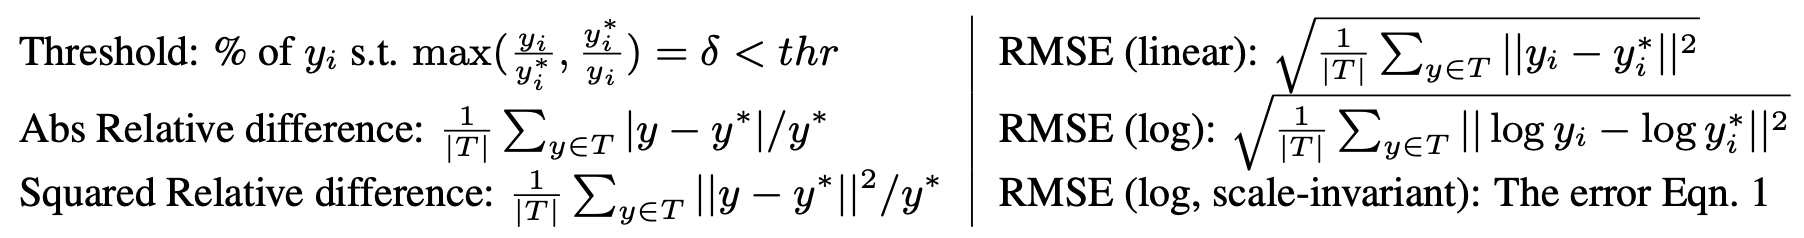

Implement the relative depth threshold and absolute relative difference measures. The RSME (linear and log) have pre-made implementations.

Some functions you will find useful: `tf.less` and `tf.greater`, `tf.reduce_sum` and `tf.reduce_mean`, `tf.ones_like`, `tf.zeros_like`, `tf.where`, `tf.math.maximum`.

In [ ]:
def relative_depth_threshold_metric(y_true, y_pred, delta_threshold):
    # calculate the max relative depths (delta), e.g. max(y_true / y_pred, y_pred / y_true)
    # and then count how many are over the `delta_threshold`
    # ...
    return None

def absolute_relative_difference_metric(y_true, y_pred):
    # calculate the mean absolute difference, e.g. mean(abs(y_pred - y_true))
    # ...
    return None

Take a batch from the validation set for evaluation:

In [ ]:
for_evaluations = next(iter(val_ds.take(1)))
predictions = model.predict(for_evaluations[0])

Run the evaluation methods:

In [ ]:
relative_depth_threshold_metric(for_evaluations[1], np.exp(predictions[:,:,:,0]), 1.25)

In [ ]:
absolute_relative_difference_metric(for_evaluations[1], np.exp(predictions[:,:,:,0]))

Unseen data without ground truth:

In [ ]:
list_ds_test = tf.data.Dataset.list_files('testing/image_2/*_10.png')
def process_path_test(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_png(image)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [192, 640])

    return image

test_ds = list_ds_test.map(process_path_test)
test_ds = test_ds.batch(5)

In [ ]:
plt.figure(figsize=(20,10))
for_test = next(iter(test_ds.take(1)))
for i in range(5):
    plt.subplot(5,2,2*i + 1),plt.imshow(np.exp(model.predict(for_test)[i,:,:,0])),plt.colorbar();
    plt.subplot(5,2,2*i + 2),plt.imshow(for_test[i].numpy());

# Conclusion

This exercise showed you how to implement an upgraded version of the important work from Eigen et al. It is a simple approach but quite powerful if it's built and trained correctly.

Your next steps in depth reconstruction can be to implement more complex methodds that achieve higher accuracy and higher resolution predictions.